In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import perlin
import palletes

%matplotlib inline

rng = np.random.default_rng()
count = 0

In [39]:

def rk4_step(df,x,t,h):
    
    k1 = df(x,t)
    k2 = df(x+0.5*h*k1,t+0.5*h)
    k3 = df(x+0.5*h*k2,t+0.5*h)
    k4 = df(x+h*k3,t+h)
    
    dx = (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    
    return x+dx


In [3]:
noise_x_4d = perlin.PerlinNoiseFactory(4,octaves=2)
noise_y_4d = perlin.PerlinNoiseFactory(4,octaves=2)

def noise_vf_periodic(pos,t,omega = 2*np.pi,r=0.1):
    
    x_circ = r*np.cos(omega*t)
    y_circ = r*np.sin(omega*t)

    return np.array([noise_x_4d(pos[0],pos[1],x_circ,y_circ),noise_y_4d(pos[0],pos[1],x_circ,y_circ)])

def exp_vf(pos,tol = 1e-6,angle=0,radius = 0):
    #pos is a Pvector
    rsq = np.dot(pos,pos)
    if rsq < tol*tol:
        return np.zeros_like(pos)
    else:
        r = np.sqrt(rsq)
        return (np.exp(-(r-radius)*(r-radius))/r)*np.array([np.cos(angle)*pos[0]-np.sin(angle)*pos[1],
                                                     np.sin(angle)*pos[0]+np.cos(angle)*pos[1]])

In [41]:
def get_lines(n_points,n_steps,step_size,df,worldsize=[1,1],init_pos = None, individual_steps = None):
    
    if init_pos is None:
        init_pos = worldsize*rng.random(2) - 0.5*worldsize
    if individual_steps is None:
        individual_steps = rng.integers(low=int(n_steps/2),high=n_steps,size=n_points)
    
    lines = []

    for i, pos_0 in enumerate(init_pos):
        #print("\t Calculating line",i+1,"of",n_points)
        pos = pos_0
        line = [pos]
        t = 0
        for j in range(individual_steps[i]):
            pos = rk4_step(df,pos,t,step_size)
            line.append(pos)
            t += step_size
        lines.append(np.array(line))
    return lines

In [110]:
size_x = 3
size_y = 3
worldsize = np.array([size_x,size_y])
radius = 0.5

n_points = 250
dt = 0.05
n_steps = 100

df = lambda x: 0.25*exp_vf(x/2,angle=0.5*np.pi,radius = radius) + 1.5*noise_vf(x,t)

n_frames = 5
Ts = np.linspace(0,1,n_frames,endpoint=False)
frame_data = []

init_pos = [worldsize*rng.random(2) - 0.5*worldsize for i in range(n_points)]
individual_steps = rng.integers(low=int(n_steps/2),high=n_steps,size=n_points)

for i,t in enumerate(Ts):
    df_t = lambda x: df(x,t)
    frame_data.append(get_lines(n_points,n_steps,dt,df_t,init_pos = init_pos, individual_steps = individual_steps))
    print("Finished frame",i+1)
print("Done!")

Finished frame 1
Done!


Finished frame 1 of 1


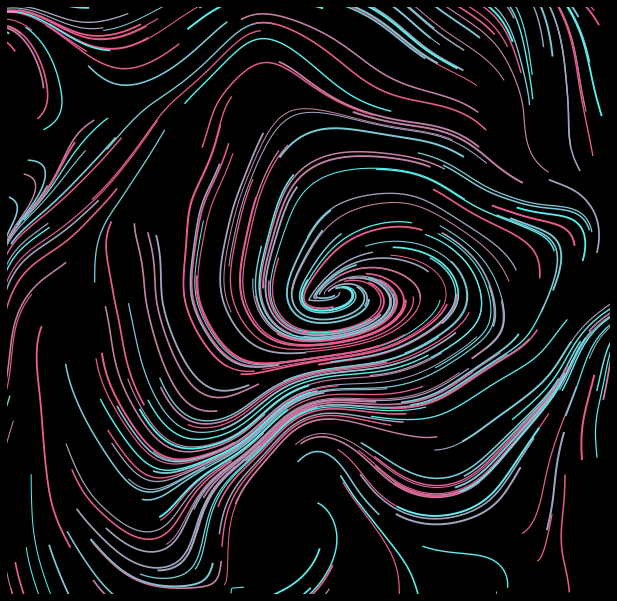

In [113]:
pallete = palletes.neon_bf

fig, ax = plt.subplots()
fig.set_size_inches(10.8,10.8)
fig.patch.set_alpha(1)
fig.set_facecolor('k')
ax.set_facecolor('k')

colors = rng.choice(pallete,size=n_points)

for count,lines in enumerate(frame_data):
    ax.cla()
    for line, steps, color in zip(lines,individual_steps,colors):

        width = (1- steps/n_steps)*3 + 1*(steps/n_steps)
        ax.plot(line[:,0],line[:,1],color=color,lw=width)

    ax.set_xlim(-0.5*size_x,0.5*size_x)
    ax.set_ylim(-0.5*size_y,0.5*size_y)
    ax.axis('off')
    ax.set_facecolor('k')
    fig.savefig('.frames/noisy_flows_'+pallete.name+'%04d.png'%count,dpi=200,bbox_inches='tight',pad_inches=0.0)
    print("Finished frame",count+1,"of",n_frames)
plt.show()

In [11]:
class Magnet:

    def __init__(self,angle,charge=-1,length=1.25):

        self.angle = angle
        self.charge = charge
        self.length = length

    def distance_sq(self,angle, r=1):

        return self.length*self.length + r*r -2*self.length*r*np.cos(angle-self.angle)

    def force(self,angle,r=1):

        d_sq = self.distance_sq(angle,r)
        return (self.charge*self.length/np.power(d_sq,2.5))*np.sin(angle-self.angle)


def magnetic_pendulum_1d(x,magnets = None, g=1, r=1,m=1):

    if magnets is None:

        magnets = [Magnet(-np.pi/4),Magnet(np.pi/4)]

    theta, omega = x

    dottheta = omega
    dotomega = - (g/r)*np.sin(theta) + (1/m)*np.array([magnet.force(theta,r) for magnet in magnets]).sum()

    return np.array([dottheta,dotomega])


In [44]:
def hopf(p,r_0 = 1,slope = 1, tol = 1e-6):


    r = np.sqrt(np.dot(p,p))
    if r < tol:
        return np.array([0,0])


    dr = -slope*(r-r_0)
    dtheta = 0.5 #+ 1/((r-r_0)**2 + 1)

    x, y = p

    dotx = (x/r)*dr -y*dtheta
    doty = (y/r)*dr + x*dtheta

    return np.array([dotx,doty])

def hopf_fun(p,r_fun,slope = 1, tol = 1e-6):

    x, y = p
    r = np.sqrt(x*x + y*y)
    if r < tol:
        return np.array([0,0])

    theta = np.arctan2(y,x)

    dr = -slope*(r-r_fun(theta))
    dtheta = 0.5 #+ 1/((r-r_0)**2 + 1)


    dotx = (x/r)*dr -y*dtheta
    doty = (y/r)*dr + x*dtheta

    return np.array([dotx,doty])



## Single image

Computing frame...
Done.
Drawing frame...
Done.


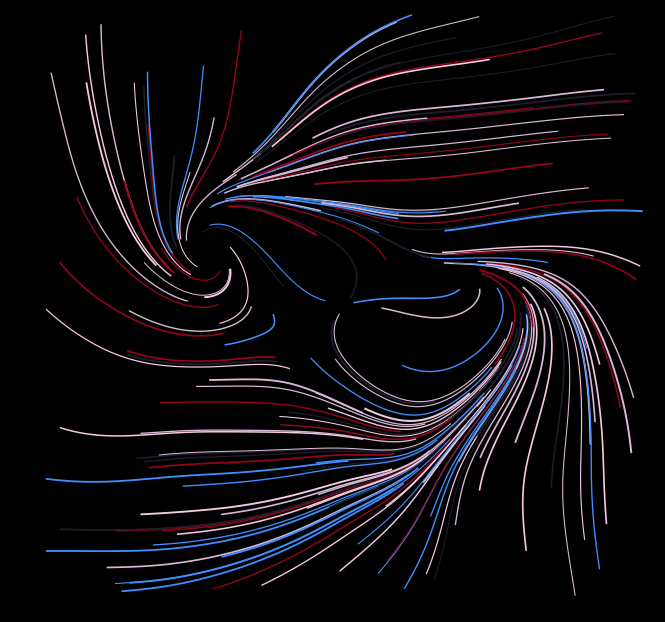

In [50]:
size_x = 2
size_y = 2
worldsize = np.array([size_x,size_y])
radius = 0.5
n_points = 150
dt = 0.025
n_steps = 100

pallete = palletes.lavender_blue

noise_x = perlin.PerlinNoiseFactory(2,octaves=2)
noise_y = perlin.PerlinNoiseFactory(2,octaves=2)

def noise_vf(pos):
    return np.array([noise_x(pos[0],pos[1]),noise_y(pos[0],pos[1])])

#df = lambda x,t: 0.5*exp_vf(x/2,angle=0.49*np.pi,radius = radius) + 1.0*noise_vf(x,t)
#df = lambda x,t: noise_vf(x,t)

#mu = 0.5
#scale = 0.5
#df = lambda x: noise_vf(x) + 0.5*np.array([scale*x[1],scale*mu*(1-scale*scale*x[0]*x[0])*x[1] - scale*x[0]]) #van der Pol
df = lambda x,t: hopf(x,r_0=radius) + 0.5*noise_vf(x)

init_pos = [worldsize*rng.random(2) - 0.5*worldsize for i in range(n_points)]
individual_steps = rng.integers(low=int(n_steps/2),high=n_steps,size=n_points)

print("Computing frame...")
lines = get_lines(n_points,n_steps,dt,df,init_pos = init_pos, individual_steps = individual_steps)
print("Done.")
print("Drawing frame...")
fig, ax = plt.subplots()
fig.set_size_inches(10.8,10.8)
fig.patch.set_alpha(1)
fig.set_facecolor('k')
ax.set_facecolor('k')

colors = rng.choice(pallete,size=n_points)
ax.cla()
for line, steps, color in zip(lines,individual_steps,colors):

    width = (1- steps/n_steps)*3 + 1*(steps/n_steps)
    ax.plot(line[:,0],line[:,1],color=color,lw=width)

ax.set_xlim(-0.5*size_x,0.5*size_x)
ax.set_ylim(-0.5*size_y,0.5*size_y)
#ax.axis('equal')
ax.set_facecolor('k')
fig.savefig('images/hopf_flow_'+pallete.name+'_%04d.png'%count,dpi=200,bbox_inches='tight',pad_inches=0.0)
print("Done.")
count += 1
plt.show()